In [ ]:
global file
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file

In [2]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import math
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt

from pycoingecko import CoinGeckoAPI


In [3]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

cg = CoinGeckoAPI()

In [4]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

In [5]:
spaces = snapshot.Query.spaces(
    first=5000,
    orderby = 'name',
    orderdirection = 'asc'
)

spaces_list = sg.query_df([
    spaces.name
])
spaces_list

In [6]:
spacename = input('spacename plz?')
# based on their url, for example "curve.eth" for  https://snapshot.org/#/curve.eth


In [7]:
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=10000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)


In [8]:
coinlist = pd.DataFrame(cg.get_coins_list())

coinlist.set_index('symbol', inplace=True)
coinlist.head(10)


,id,name
symbol,,
zoc,01coin,01coin
algohalf,0-5x-long-algorand-token,0.5X Long Algorand
althalf,0-5x-long-altcoin-index-token,0.5X Long Altcoin Index
asdhalf,0-5x-long-ascendex-token-token,0.5X Long AscendEx
bchhalf,0-5x-long-bitcoin-cash-token,0.5X Long Bitcoin Cash
half,0-5x-long-bitcoin-token,0.5X Long Bitcoin
adahalf,0-5x-long-cardano-token,0.5X Long Cardano
linkhalf,0-5x-long-chainlink-token,0.5X Long Chainlink
atomhalf,0-5x-long-cosmos-token,0.5X Long Cosmos


In [10]:
tokens =  snapshot.Query.spaces(
  where=[
    snapshot.Query.space.id == spacename, ##'fuse.eth'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)
token_symbol = sg.query_df(tokens.symbol)
token_symbol.columns = ['symbol']

token_symbol


,symbol
0,OHM


In [ ]:
#WHYYYY doesn't this work?
token_id = pd.merge('coinlist', 'token_symbol', on='symbol')

In [ ]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.id,
    proposals.body,
    proposals.scores_total
])

In [ ]:
proposals_choices = sg.query(proposals.choices)

In [ ]:
proposals_choices = pd.DataFrame(proposals_choices)

In [ ]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

In [ ]:
##let's view the output just to make sure
olympus_governance_view.head(5)

In [ ]:
#let's remove duplicate rows the easy way, and add the name of the DAO to the table
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean.insert(0, 'DAO', spacename)
olympus_governance_view_clean.head(10)

In [ ]:
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'_proposals.csv'
olympus_governance_view_clean.to_csv(path, index = False)

In [ ]:
total_proposals = len(olympus_governance_view_clean)
total_proposals

In [ ]:
proposal_id = olympus_governance_view_clean.iloc[0,2]
proposal_id

In [ ]:
vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=10000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [ ]:
voting_snapshots_list = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [ ]:
voting_snapshots_list.head(10)

In [ ]:
x=0
while x <total_proposals:
    proposal_id = olympus_governance_view_clean.iloc[x,2]

    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=10000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,0))
    ##clear_output(wait=True)

print(len(voting_snapshots_list),' records')

In [ ]:
#spit out the file
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

In [ ]:
#I join these two tables to create my charts as it makes life easier. We are going to build the charts here now, so here we go
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view_clean, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"]
governance_data.head(10)

In [ ]:
#Spit out the file, but save it in its own folder for easy access
final_file = file+'\\'+'final'
final_raw_file = final_file
os.makedirs(final_raw_file, exist_ok=True)
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'
governance_data.to_csv(final_path, index = False)

In [ ]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created "
                       "    ,proposals_title "
                    "       , to_timestamp(min(votes_Created::bigint)) proposal_date "
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       "    , proposals_title "
                       ""
                       "Order by "
                       "    7 asc, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)


In [ ]:
#leaders = crunch_data.loc[crunch_data['proposal_voter_rank'] <=3]
#leader_count = leaders.votes_voter.nunique()
#leader_count
#DONT ASK ME WHY THIS DIDNT WORK. HAVE TO DO IT THE UGLY WAY

leader_ranks = db.query("with leader_ranks as "
                        "(Select distinct "
                        "   B.Proposal"
                        "   ,B.votes_voter"
                        "   ,B.proposal_voter_rank "
                        "   ,(B.proposal_voter_rank +1) as leader_rank "
                        "From "
                        "   (select "
                               "Proposal"
                               ",votes_voter "
                               ",votes_choice"
                               ",votes_vp"
                               ",votes_created  "
                               ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                               ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                               ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                               ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                           "    ,round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                               ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                               ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                               ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                               ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                           "from "
                           "    governance_data  "
                               ""
                           "Group by "
                           "    Proposal"
                           "    ,votes_voter"
                           "    ,votes_choice"
                           "    , votes_vp "
                           "    , votes_created "
                           ""
                           "Order by "
                           "    Proposal, "
                           "    votes_vp desc "
                           "    , votes_created asc) B "
                        "where "
                        "   B.cum_percentage_of_total_vp<=0.5) "
                        ""
                        "Select "
                        "   *"
                        "From crunch_data A"
                        "   Join leader_ranks B on A.proposal_voter_rank = B.leader_rank and A.Proposal = B.Proposal"
                        ""
                    ).df()
leader_ranks




In [ ]:
dao_members = crunch_data.groupby('DAO').votes_voter.nunique()
dao_members = dao_members.iloc[0]
leader_count =leader_ranks.votes_voter.nunique()
elite = round((leader_count)/(dao_members),4)

print(dao_members, "{0:.2%}".format(elite))


In [ ]:
crunch_data.head(10)

In [ ]:
crunch_data.describe()

In [ ]:
##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(crunch_data_path, index = False)

In [ ]:
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp", "percentage_voters_counted"].agg("mean").reset_index()
data_means.insert(0, 'DAO', spacename)

In [ ]:
data_means_file =final_file+'\\'+spacename+'data_means_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(data_means_file, index = False)

In [ ]:
plt.rc("figure", figsize=(40, 20))
sns.set_style("whitegrid")
plt.rc("font", size=25)
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()
##print(data_means)
plot_title = spacename + ' snapshots % of vote along population with Average as X'

ax=sns.scatterplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped").set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')
chart = sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp",zorder=3, s=600,marker='X',color = 'orange')
#and save the chart file, too
plt.savefig(final_file+'\\'+spacename+' vote power distribution.png', dpi=100)

means_data_path =final_file+'\\'+spacename+'_means_'+'.csv'
data_means.to_csv(means_data_path, index = False)

print(chart)
data_means

The chart above shows what % of all possible votes has been cast (Y axis) as each incremental percent of the voting population casts their vote (X axis). Each line is a Proposal and has a unique color, so that a dot on each percent point represents what % of total voting power was accumulated by that group. The color represents which vote was cast.
The Orange X shows the average % of power accumulated across all elections.

In [ ]:
voters_df = db.query("select  proposals_title, count(distinct votes_voter) total_voters,  min(proposal_date) proposal_date from crunch_data group by 1 order by 1 asc").df()

chart = sns.barplot(data=voters_df,x="proposals_title",y="total_voters", color = 'orange')
#and save the chart file, too

print(chart)



AxesSubplot(0.125,0.125;0.775x0.755)


/Users/ianbrillembourg/PycharmProjects/Snapshotsurfer/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ianbrillembourg/PycharmProjects/Snapshotsurfer/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ianbrillembourg/PycharmProjects/Snapshotsurfer/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ianbrillembourg/PycharmProjects/Snapshotsurfer/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ianbr

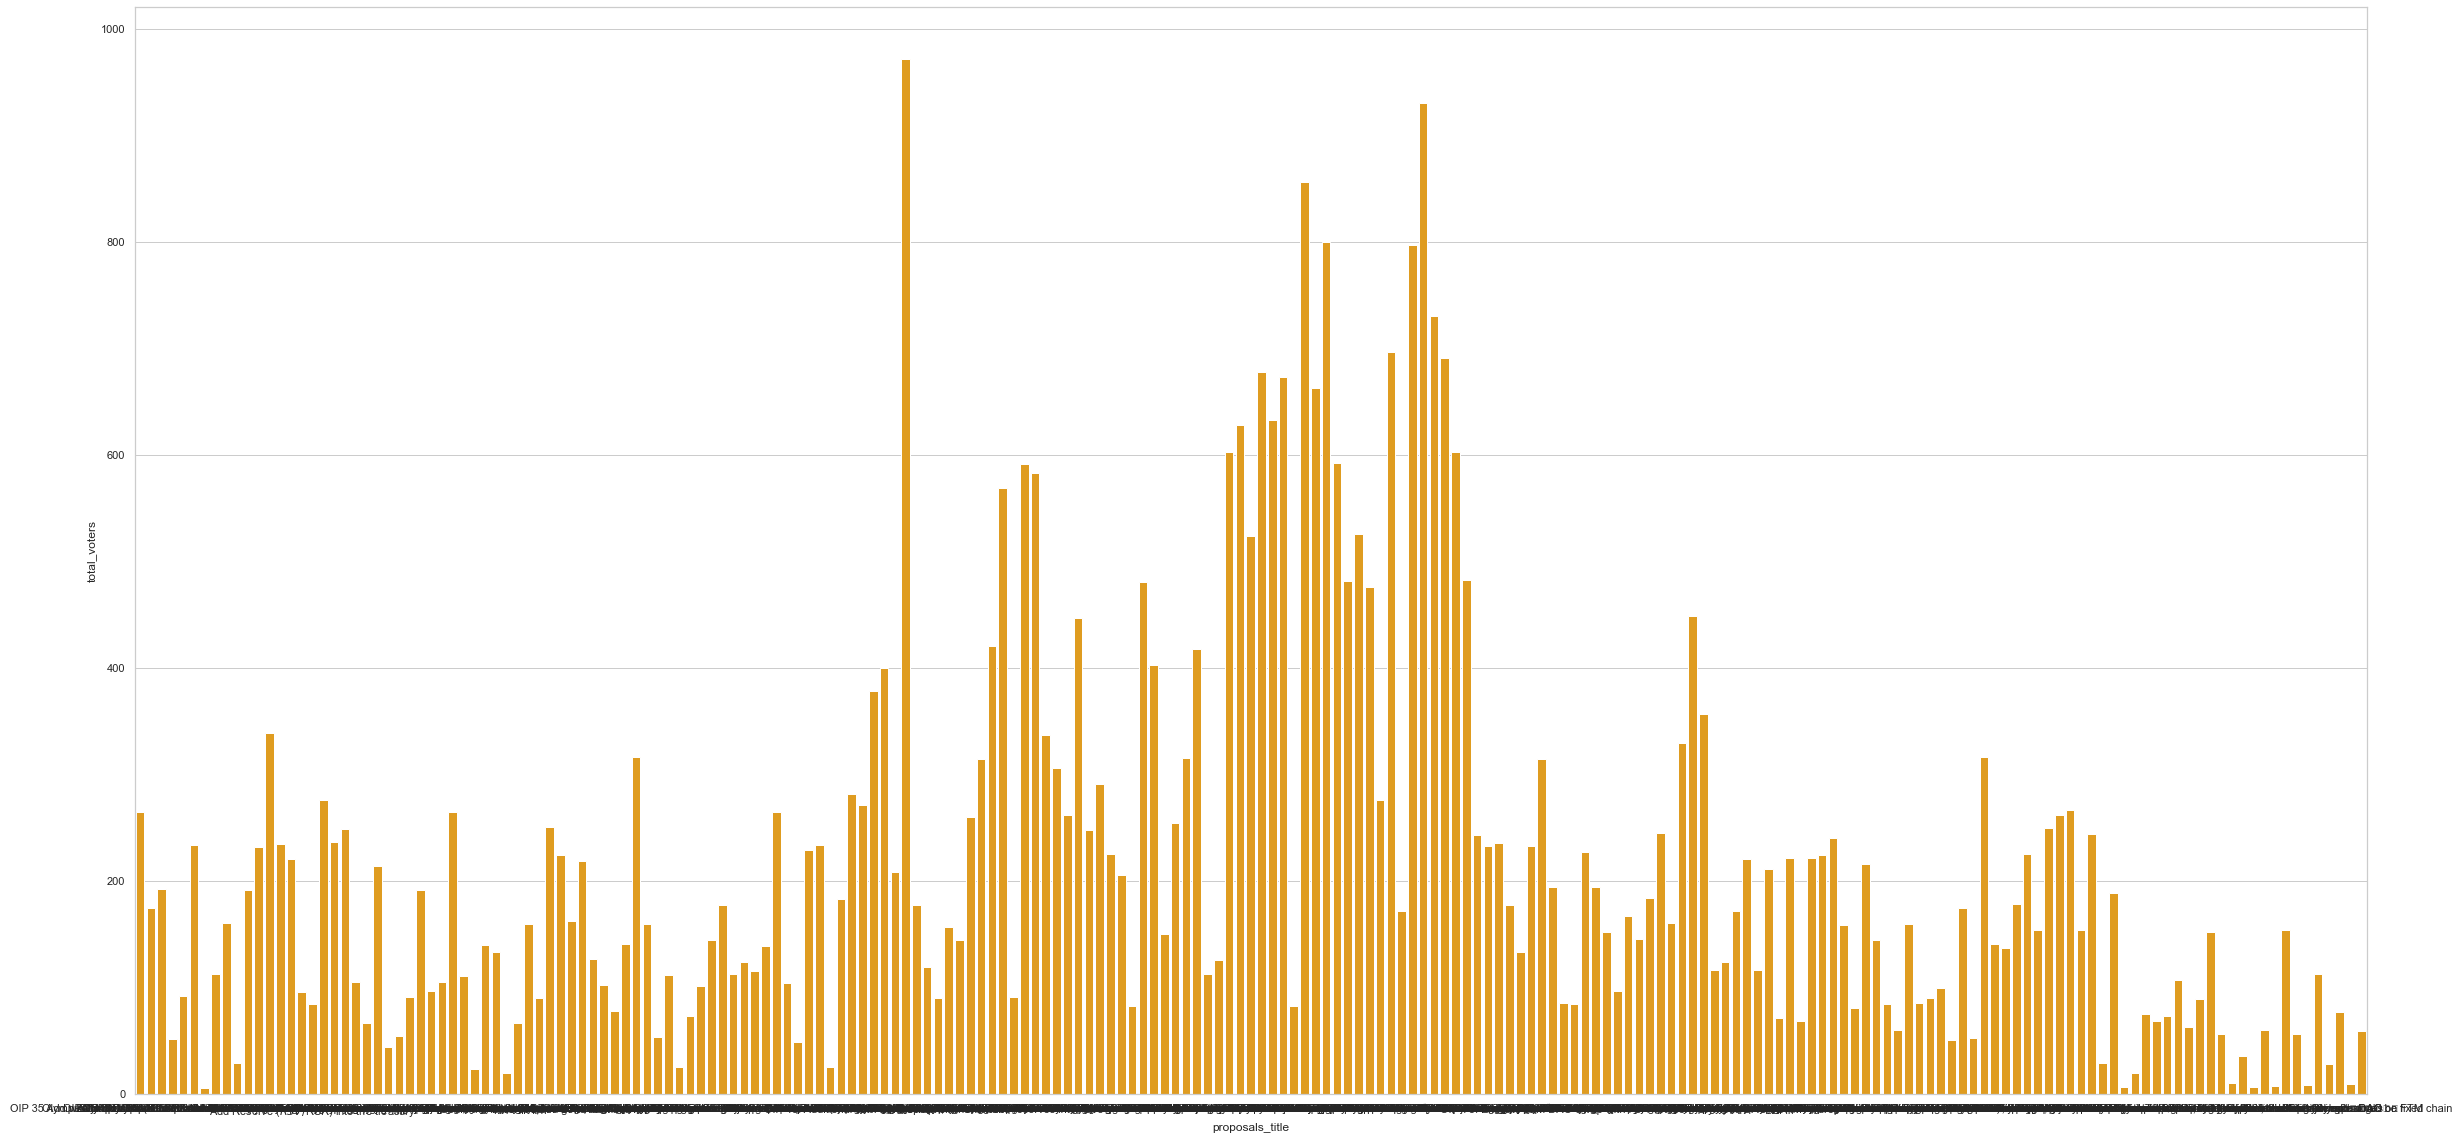

In [77]:
voters_df = db.query("select  proposals_title, count(distinct votes_voter) total_voters,  min(proposal_date) proposal_date from crunch_data group by 1 order by 1 asc").df()

chart = sns.barplot(data=voters_df,x="proposals_title",y="total_voters", color = 'orange')
#and save the chart file, too

print(chart)



In [ ]:
p50 = db.query("select min(percentage_voters_counted) "
               "from data_means  where cum_percentage_of_total_vp>=0.5 ").df()
p50display = round(100*(p50.iloc[0,0]),2)
print('On average, a proposal at ', spacename, 'takes ',p50display,'% of the voting population.')

print('A total of ',leader_count, 'wallets have driven the result of all proposals at',spacename,)
print('That\'s', ("{0:.2%}".format(elite)), 'of all DAO voters.')